Interpolando eixo X: i_max=51 -> new_i=500, sigma=0.00961 cm
Novo VoxelSize[0]: 0.001922 cm


Digite a relação Vale-Pico (VPR) desejada:  0.75



Buscando deslocamento para VPR alvo = 0.750
  Solução selecionada: d=0.1051 cm, VPR=0.750
Deslocamento necessário: 0.10512 cm
Delta em voxels: 54.571
Arquivo 'dados_PDP50.txt' salvo com sucesso.


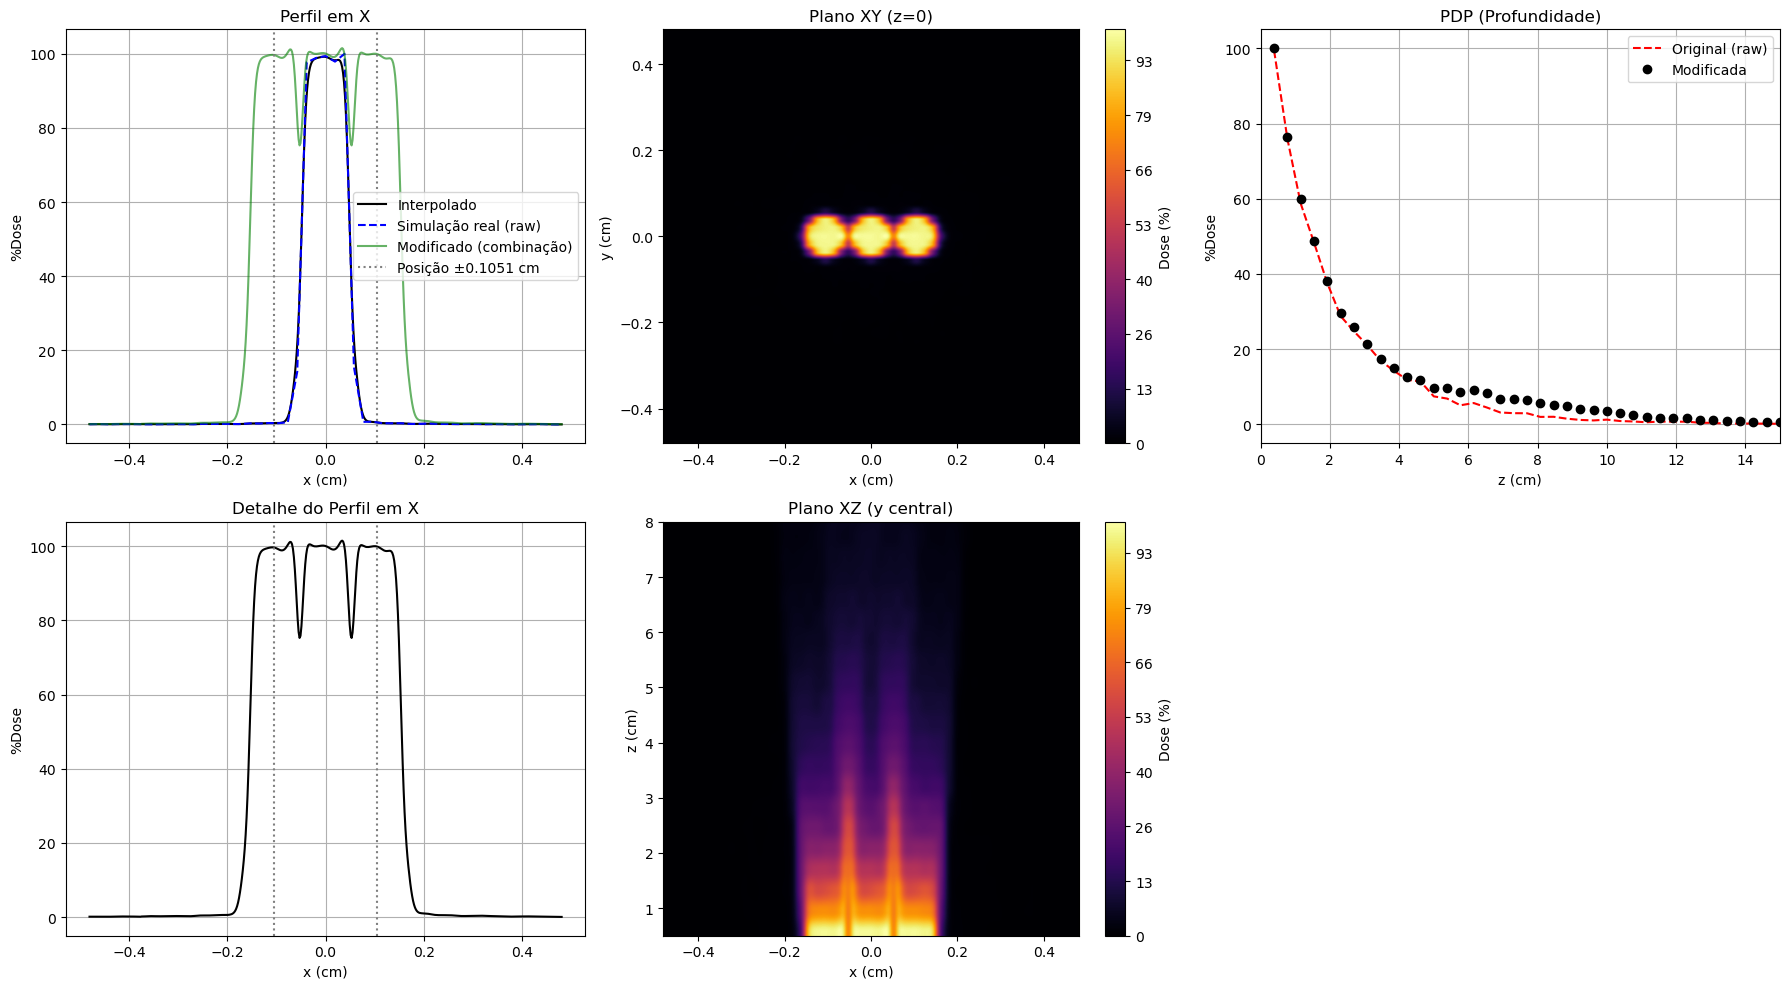

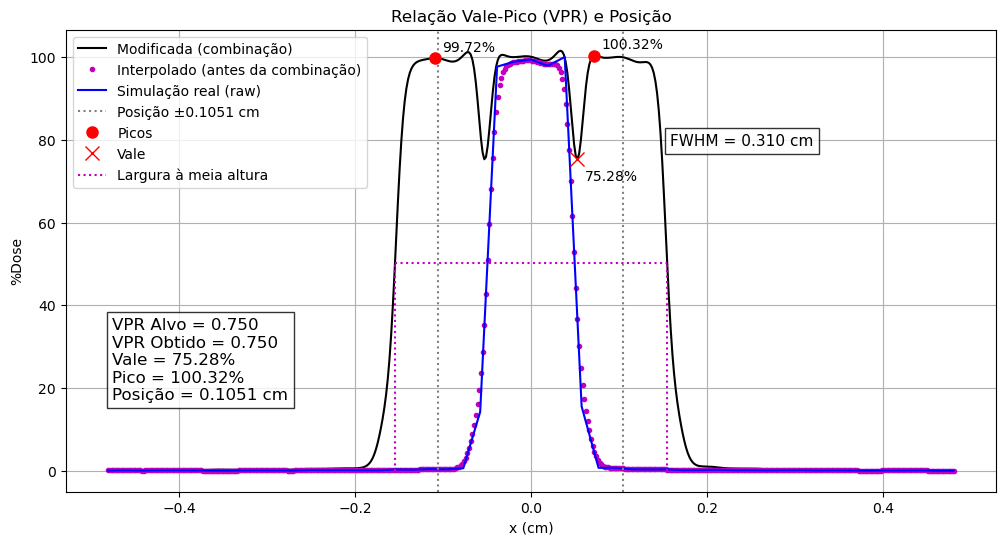


VERIFICAÇÃO DE PRECISÃO
VPR Alvo:    0.7500
VPR Obtido:  0.7504
Erro:        0.000424
Posição:     0.1051 cm
Delta voxels:54.571


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.signal import find_peaks
from scipy.ndimage import shift
from functools import lru_cache

# ========== CONFIGURAÇÕES ==========
plt.style.use('default')
cmap = 'inferno'
# ========== LEITURA DOS DADOS ==========
arquivo = './Kernel 50/3d-dose.dat'
Arq = np.loadtxt(arquivo)

i_max, j_max, k_max = map(int, np.max(Arq[:, 5:8], axis=0))
x_min, x_max = Arq[:, 0].min(), Arq[:, 0].max()
y_min, y_max = Arq[:, 1].min(), Arq[:, 1].max()
z_min, z_max = Arq[:, 2].min(), Arq[:, 2].max()

VoxelSize = [(x_max - x_min)/i_max, (y_max - y_min)/j_max, (z_max - z_min)/k_max]
EscalaX = np.linspace(x_min + VoxelSize[0]/2, x_max - VoxelSize[0]/2, i_max)
EscalaY = np.linspace(y_min + VoxelSize[1]/2, y_max - VoxelSize[1]/2, j_max)
EscalaZ = np.linspace(z_min + VoxelSize[2]/2, z_max - VoxelSize[2]/2, k_max)

Dose = np.zeros((i_max, j_max, k_max))
for linha in Arq:
    i, j, k = int(linha[5]) - 1, int(linha[6]) - 1, int(linha[7]) - 1
    Dose[i, j, k] = linha[3]

Dose_raw = Dose.copy()
EscalaX_raw = EscalaX.copy()
max_dose_raw = np.max(Dose_raw)
#salvamento dos dados originais do 3d dose
Dose_filt = Dose.copy()

# ========== INTERPOLAÇÃO GAUSSIANA OTIMIZADA ==========
# REDUZIDO PARA ACELERAR
GAUSSIAN_UPSAMPLE_FACTOR = 10  # quantas vezes mais eu quero ter pontos de dose
MAX_NEW_I = 500                #limita a quantidade de voxels
SIGMA_FACTOR = 0.5 #o quanto de borrão eu permito ter entre os voxels, valores mais próximos de 1 perda de detalhes. 

# Calcula novo número de pontos
proposed_new_i = int(i_max * GAUSSIAN_UPSAMPLE_FACTOR) #
new_i = min(proposed_new_i, MAX_NEW_I) #escolhe o menor valor para ser a nova quantidade de pontos de dose
if new_i <= i_max:
    new_i = i_max * 2  #define como padrão minimo dobrar os pontos de dose para que haja a ampliaçao minima 

nova_EscalaX = np.linspace(EscalaX[0], EscalaX[-1], new_i)  #cria novos voxels igualmente espaçados com tamanhos menores entre os voxels originais 
sigma = SIGMA_FACTOR * VoxelSize[0]  #como cada ponto de radiação vai influenciar os pontos vizinhos num raio de aproximadamente voxel*sigmafactor

print(f"Interpolando eixo X: i_max={i_max} -> new_i={new_i}, sigma={sigma:.5f} cm")
print(f"Novo VoxelSize[0]: {(nova_EscalaX[-1] - nova_EscalaX[0])/new_i:.6f} cm") #mostra o tamanho novo do voxel

# OTIMIZAÇÃO: Construção vetorizada mais eficiente
X_old = EscalaX.reshape(1, -1) #pontos da matriz onde sabemos as doses pelo 3d dose
X_new = nova_EscalaX.reshape(-1, 1) #Agora quero colocar mais pontos entre os pontos do 3d-dose

# Cálculo otimizado da matriz de pesos
delta_sq = ((X_new - X_old) / sigma) ** 2  #como é a influencia dos pontos originais nos dados? sigma pqueno os mais prox influencia mais
W = np.exp(-0.5 * delta_sq) #0.5 faz com que haja o decaimento da dose nos pontos distantes baseado no comportamento gaussiano 
W /= W.sum(axis=1, keepdims=True) #isso garante que não haverá pontos que criem dose extra na matriz

# Aplicação vetorizada dos pesos
Dose_interp = np.zeros((new_i, j_max, k_max), dtype=np.float32)  # interpolação da dose com float32 para economia de memória 
for j in range(j_max):
    Dose_interp[:, j, :] = W @ Dose[:, j, :] #aplicando a influencia de alteração dos voxels com pontos de dose em x para y

# Substituir variáveis
Dose = Dose_interp.astype(np.float64)  # Volta para float64 para cálculos precisos
Dose_filt = Dose.copy() #copia de segurança caso precise voltar aos dados 
EscalaX = nova_EscalaX #novas medidas do eixo x 
VoxelSize[0] = (EscalaX[-1] - EscalaX[0]) / (len(EscalaX) - 1) #novas medidas dos voxels 
i_max = Dose.shape[0] #numero de pontos na direção x com a ampliação
max_dose_original = max_dose_raw #referencia original para comparação 

# ========== CACHE PARA ACELERAR CÁLCULOS REPETIDOS ==========
_vpr_cache = {}

def calcular_vpr(distancia_x):
    # Cache para evitar recálculos
    cache_key = round(distancia_x, 6)  # Arredonda para 6 casas decimais para evitar problemas de precisão
    if cache_key in _vpr_cache:
        return _vpr_cache[cache_key] #se esse fracionamento ja foi calculado antes ele mostra mais rapido
    
    delta_voxels_preciso = distancia_x / VoxelSize[0] #distancia física convertida em voxels
    
    if abs(delta_voxels_preciso) >= Dose_filt.shape[0] - 1 or delta_voxels_preciso <= 0: #impede os cálculos fora da região de interesse 
        result = (0.0, None, None, None)
        _vpr_cache[cache_key] = result #otimização
        return result
    
    # OTIMIZAÇÃO: Usa order=1 (linear) 
    # Remove prefilter=True que adiciona processamento extra
    Dose_pos = shift(Dose, shift=[-delta_voxels_preciso, 0, 0], 
                      order=1, mode='constant', cval=0.0) #simula o que acontece quando a fonte de radiação se move pra esquerda 
    #Fora da area de tratamento dose 0, delta voxels é o passo em voxel 
    Dose_neg = shift(Dose, shift=[delta_voxels_preciso, 0, 0], 
                      order=1, mode='constant', cval=0.0) #mesmo princípio para a direita
    
    Dose_comb = Dose + Dose_pos + Dose_neg  #superposição das doses
    
    j_central = Dose_comb.shape[1] // 2 
    dose_x_mod = 100 * Dose_comb[:, j_central, 0] / max_dose_original #extrai o perfil de dose ao longo do eixo X no plano central YZ
    
    # Detecção de picos otimizada
    min_distance = max(1, int(0.5 * delta_voxels_preciso)) #picos pelo menos a metade da distancia do movimento e minimo 1 voxel de distancia
    
    peaks, _ = find_peaks(dose_x_mod, 
                         distance=min_distance, 
                         prominence=0.5,
                         height=5) #procurando os picos de radiação separados pela distancia minima
    
    if len(peaks) < 3:
        peaks, _ = find_peaks(dose_x_mod, 
                             distance=max(1, int(0.3 * delta_voxels_preciso)), 
                             prominence=0.1,
                             height=1) #muda os critérios para encontrar os picos 
    
    # Lógica de identificação de picos 
    if len(peaks) >= 3:
        peaks_sorted = sorted(peaks, key=lambda x: EscalaX[x]) #ordena picos por posição física
        idx_central = peaks_sorted[np.argmin(np.abs(EscalaX[peaks_sorted]))]
        
        peaks_left = [p for p in peaks_sorted if EscalaX[p] < EscalaX[idx_central] - 0.01] 
        peaks_right = [p for p in peaks_sorted if EscalaX[p] > EscalaX[idx_central] + 0.01] #separação de picos a direita e a esquerda
        
        if peaks_left:
            idx_neg = peaks_left[np.argmin(np.abs(EscalaX[peaks_left] + distancia_x))] 
        else:
            idx_neg = np.argmin(np.abs(EscalaX + distancia_x))
            
        if peaks_right:
            idx_pos = peaks_right[np.argmin(np.abs(EscalaX[peaks_right] - distancia_x))]
        else:
            idx_pos = np.argmin(np.abs(EscalaX - distancia_x))
    
    elif len(peaks) == 2:
        idx_pos = peaks[np.argmin(np.abs(EscalaX[peaks] - distancia_x))]
        idx_neg = peaks[np.argmin(np.abs(EscalaX[peaks] + distancia_x))]
    
    else:
        idx_pos = np.argmin(np.abs(EscalaX - distancia_x))
        idx_neg = np.argmin(np.abs(EscalaX + distancia_x))
        
        # Ajusta para máximo local no maximo entre 5 ptos
        window = 5
        for idx in [idx_pos, idx_neg]:
            if 0 < idx < len(dose_x_mod) - 1:
                start = max(0, idx - window)
                end = min(len(dose_x_mod), idx + window + 1)
                local_max_idx = start + np.argmax(dose_x_mod[start:end])
                if idx == idx_pos:
                    idx_pos = local_max_idx
                else:
                    idx_neg = local_max_idx
    
    # Busca o vale
    if idx_neg < idx_pos:
        regiao_vale = dose_x_mod[idx_neg:idx_pos+1]
        if len(regiao_vale) > 0:
            idx_vale = idx_neg + np.argmin(regiao_vale)
        else:
            idx_vale = (idx_neg + idx_pos) // 2
    else:
        regiao_vale = dose_x_mod[idx_pos:idx_neg+1]
        if len(regiao_vale) > 0:
            idx_vale = idx_pos + np.argmin(regiao_vale)
        else:
            idx_vale = (idx_pos + idx_neg) // 2
    
    vale = dose_x_mod[idx_vale] if 0 <= idx_vale < len(dose_x_mod) else 0
    pico_pos = dose_x_mod[idx_pos] if 0 <= idx_pos < len(dose_x_mod) else 0
    pico_neg = dose_x_mod[idx_neg] if 0 <= idx_neg < len(dose_x_mod) else 0
    pico = max(pico_pos, pico_neg)
    
    vpr = vale / pico if pico != 0 else 0.0 #Calcula vpr
    result = (vpr, idx_pos, idx_neg, idx_vale)
    
    _vpr_cache[cache_key] = result #armazena o resultado em cache
    return result

# ========== BUSCA OTIMIZADA ==========
def encontrar_deslocamento_otimizado(vpr_alvo):
    """
    Versão otimizada com menos pontos de varredura
    """
    def f(d):
        vpr, _, _, _ = calcular_vpr(d)
        return vpr - vpr_alvo
    
    d_min, d_max = 0.001, min(0.4, EscalaX[-1] - 0.001)
    
    # OTIMIZAÇÃO: Reduz pontos de varredura de 500 para 100
    n_points = 100  # REDUZIDO DRASTICAMENTE
    test_points = np.linspace(d_min, d_max, n_points)
    
    print(f"\nBuscando deslocamento para VPR alvo = {vpr_alvo:.3f}")
    
    # Varredura inicial rápida
    vpr_values = [calcular_vpr(d)[0] for d in test_points]
    vpr_array = np.array(vpr_values)
    
    # Encontra cruzamentos
    crossings = []
    for i in range(len(vpr_array) - 1):
        if (vpr_array[i] - vpr_alvo) * (vpr_array[i+1] - vpr_alvo) < 0:
            try:
                # Refinamento local apenas onde necessário
                d_cross = brentq(f, test_points[i], test_points[i+1], xtol=1e-4)  # Tolerância relaxada
                vpr_cross, _, _, _ = calcular_vpr(d_cross)
                crossings.append((d_cross, vpr_cross, abs(vpr_cross - vpr_alvo)))
            except:
                # Interpolação linear simples
                alpha = (vpr_alvo - vpr_array[i]) / (vpr_array[i+1] - vpr_array[i])
                d_cross = test_points[i] * (1 - alpha) + test_points[i+1] * alpha
                vpr_cross = vpr_alvo  # Aproximação
                crossings.append((d_cross, vpr_cross, 0))
    
    # Se não encontrou cruzamentos, pega o mais próximo
    if not crossings:
        idx_closest = np.argmin(np.abs(vpr_array - vpr_alvo))
        crossings.append((test_points[idx_closest], vpr_array[idx_closest], 
                         abs(vpr_array[idx_closest] - vpr_alvo)))
    
    # Ordena por erro
    crossings.sort(key=lambda x: x[2])
    
    # Seleção rápida baseada em heurísticas
    if vpr_alvo < 0.3:
        preferred_range = (0.10, 0.25)
    elif vpr_alvo < 0.6:
        preferred_range = (0.08, 0.20)
    else:
        preferred_range = (0.10, 0.30)
        # Remove soluções muito pequenas para VPR alto
        crossings = [(d, vpr, err) for d, vpr, err in crossings if d > 0.05]
    
    # Seleciona melhor solução
    for d, vpr, err in crossings:
        if preferred_range[0] <= d <= preferred_range[1]:
            print(f"  Solução selecionada: d={d:.4f} cm, VPR={vpr:.3f}")
            return d
    
    # Fallback
    if crossings:
        best = crossings[0]
        print(f"  Solução: d={best[0]:.4f} cm, VPR={best[1]:.3f}")
        return best[0]
    
    return None

# ========== INPUT ==========
vpr_alvo = float(input("Digite a relação Vale-Pico (VPR) desejada: "))
deslocamento_otimo = encontrar_deslocamento_otimizado(vpr_alvo)

# ========== PLOTAGEM OTIMIZADA ==========
if deslocamento_otimo is not None:
    print(f"Deslocamento necessário: {deslocamento_otimo:.5f} cm")
    
    delta_voxels_preciso = deslocamento_otimo / VoxelSize[0]
    print(f"Delta em voxels: {delta_voxels_preciso:.3f}")
    
    # Usa shift com order=1 para plotagem também (mais rápido)
    Dose_pos = shift(Dose_filt, shift=[-delta_voxels_preciso, 0, 0], 
                      order=1, mode='constant', cval=0.0)
    Dose_neg = shift(Dose_filt, shift=[delta_voxels_preciso, 0, 0], 
                      order=1, mode='constant', cval=0.0)
    Dose_comb = Dose + Dose_pos + Dose_neg
    
    i_central = Dose_comb.shape[0] // 2
    j_central = Dose_comb.shape[1] // 2
    dose_x_mod = 100 * Dose_comb[:, j_central, 0] / max_dose_original
    dose_x_interp = 100 * Dose[:, j_central, 0] / max_dose_original
    dose_x_sim = 100 * Dose_raw[:, j_central, 0] / max_dose_raw
    
    dose_z_mod = 100 * Dose_comb[i_central, j_central, :] / max_dose_original
    x_i_central = EscalaX[i_central]
    idx_raw_i_central = np.argmin(np.abs(EscalaX_raw - x_i_central))
    dose_z_orig = 100 * Dose_raw[idx_raw_i_central, j_central, :] / max_dose_original
    
    vpr_final, idx_pos, idx_neg, idx_vale = calcular_vpr(deslocamento_otimo)
    
    # Cálculo de métricas
    if idx_pos is not None and idx_neg is not None and idx_vale is not None:
        pico_pos = dose_x_mod[idx_pos]
        pico_neg = dose_x_mod[idx_neg]
        pico_max_valor = max(pico_pos, pico_neg)
        vale = dose_x_mod[idx_vale]
        
        pico_max_idx = idx_pos if pico_pos >= pico_neg else idx_neg
        pico_val = dose_x_mod[pico_max_idx]
        half_val = pico_val / 2.0
        
        # FWHM simplificado
        left_x = None
        for ii in range(pico_max_idx - 1, -1, -1):
            if dose_x_mod[ii] <= half_val:
                left_x = EscalaX[ii]
                break
        if left_x is None:
            left_x = EscalaX[0]
        
        right_x = None
        for ii in range(pico_max_idx + 1, len(dose_x_mod)):
            if dose_x_mod[ii] <= half_val:
                right_x = EscalaX[ii]
                break
        if right_x is None:
            right_x = EscalaX[-1]
        
        fwhm = right_x - left_x
    else:
        pico_pos = pico_neg = pico_max_valor = vale = 0
        pico_max_idx = None
        half_val = None
        left_x = right_x = None
        fwhm = None
    
    # ========== PLOTS ==========
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Perfil em X
    axs[0,0].plot(EscalaX, dose_x_interp, 'k-', label='Interpolado')
    axs[0,0].plot(EscalaX_raw, dose_x_sim, 'b--', label='Simulação real (raw)')
    axs[0,0].plot(EscalaX, dose_x_mod, 'g-', alpha=0.6, label='Modificado (combinação)')
    axs[0,0].axvline(deslocamento_otimo, color='gray', linestyle=':', 
                     label=f'Posição ±{deslocamento_otimo:.4f} cm')
    axs[0,0].axvline(-deslocamento_otimo, color='gray', linestyle=':')
    axs[0,0].set(title='Perfil em X', xlabel='x (cm)', ylabel='%Dose')
    axs[0,0].legend()
    axs[0,0].grid()
    
    img1 = axs[0,1].imshow(Dose_comb[:,:,0].T, cmap=cmap, origin='lower', vmin=0, vmax=np.max(Dose_comb), 
                          extent=[EscalaX[0], EscalaX[-1], EscalaY[0], EscalaY[-1]], 
                          aspect='auto')
    cbar = fig.colorbar(img1, ax=axs[0,1])
    cbar.set_label('Dose (%)')
    cbar.ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda val, pos: f'{(val/np.max(Dose_comb))*100:.0f}')
)
    axs[0,1].set(title='Plano XY (z=0)', xlabel='x (cm)', ylabel='y (cm)')
    
    axs[0,2].plot(EscalaZ, dose_z_orig, 'r--', label='Original (raw)')
    axs[0,2].plot(EscalaZ, dose_z_mod, 'ko', label='Modificada')
    axs[0,2].set(title='PDP (Profundidade)', xlabel='z (cm)', ylabel='%Dose')
    axs[0,2].set_xlim(0, 15)
    axs[0,2].grid()
    axs[0,2].legend()
    # Salvar os dados do gráfico PDP em um arquivo TXT
    with open("dados_PDP.txt", "w") as f: 
        f.write("Profundidade(mm)\tDose\n")  # Cabeçalho
        for profundidade, dose in zip(EscalaZ, dose_z_mod):
            f.write(f"{profundidade:.3f}\t{dose:.6f}\n")

    print("Arquivo 'dados_PDP50.txt' salvo com sucesso.")

    
    axs[1,0].plot(EscalaX, dose_x_mod, 'k-')
    axs[1,0].axvline(deslocamento_otimo, color='gray', linestyle=':')
    axs[1,0].axvline(-deslocamento_otimo, color='gray', linestyle=':')
    axs[1,0].set(title='Detalhe do Perfil em X', xlabel='x (cm)', ylabel='%Dose')
    axs[1,0].grid()
    max_xz = np.max(Dose_comb[:, j_central, :])
    img2 = axs[1,1].imshow(
    Dose_comb[:, j_central, :].T,
    cmap=cmap,
    origin='lower',
    vmin=0,
    vmax=max_xz,  # normaliza para 100% nesse corte
    extent=[EscalaX[0], EscalaX[-1], EscalaZ[0], EscalaZ[-1]],
    aspect='auto'
)

    cbar2 = fig.colorbar(img2, ax=axs[1,1], label='Dose (%)')
    cbar2.ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda val, pos: f'{(val/max_xz)*100:.0f}')
)

    axs[1,1].set(title='Plano XZ (y central)', xlabel='x (cm)', ylabel='z (cm)')
    axs[1,1].set_ylim(0.5, 8)
    axs[1,2].axis('off')
    plt.tight_layout()
    plt.show()
    
    # ========== PLOT DO GRÁFICO DA VPR ==========
    plt.figure(figsize=(12, 6))
    plt.plot(EscalaX, dose_x_mod, 'k-', markersize=3,label='Modificada (combinação)')
    plt.plot(EscalaX, dose_x_interp, 'mo',markersize=3, label='Interpolado (antes da combinação)')
    plt.plot(EscalaX_raw, dose_x_sim, 'b-', label='Simulação real (raw)')
    plt.axvline(deslocamento_otimo, color='gray', linestyle=':', 
                label=f'Posição ±{deslocamento_otimo:.4f} cm')
    plt.axvline(-deslocamento_otimo, color='gray', linestyle=':')
    plt.grid(True)
    
    if idx_pos is not None and idx_neg is not None and idx_vale is not None:
        plt.plot(EscalaX[idx_pos], pico_pos, 'ro', markersize=8, label='Picos')
        plt.plot(EscalaX[idx_neg], pico_neg, 'ro', markersize=8)
        plt.plot(EscalaX[idx_vale], vale, 'rx', markersize=10, label='Vale')
        
        plt.annotate(f'{pico_pos:.2f}%', (EscalaX[idx_pos], pico_pos), 
                     xytext=(5, 5), textcoords='offset points', fontsize=10)
        plt.annotate(f'{pico_neg:.2f}%', (EscalaX[idx_neg], pico_neg), 
                     xytext=(5, 5), textcoords='offset points', fontsize=10)
        plt.annotate(f'{vale:.2f}%', (EscalaX[idx_vale], vale), 
                     xytext=(5, -15), textcoords='offset points', fontsize=10)
        
        if fwhm is not None:
            plt.hlines(half_val, left_x, right_x, colors='m', linestyles=':', 
                      label='Largura à meia altura')
            plt.vlines([left_x, right_x], 0, half_val, colors='m', linestyles=':')
            plt.annotate(f'FWHM = {fwhm:.3f} cm', xy=(0.65, 0.75), 
                        xycoords='axes fraction', fontsize=11, 
                        bbox=dict(facecolor='white', alpha=0.8))
    
    plt.text(0.05, 0.2, 
             f'VPR Alvo = {vpr_alvo:.3f}\n'
             f'VPR Obtido = {vpr_final:.3f}\n'
             f'Vale = {vale:.2f}%\n'
             f'Pico = {pico_max_valor:.2f}%\n'
             f'Posição = {deslocamento_otimo:.4f} cm', 
             transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('Relação Vale-Pico (VPR) e Posição')
    plt.xlabel('x (cm)')
    plt.ylabel('%Dose')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # VERIFICAÇÃO 
    print("\n" + "="*60)
    print("VERIFICAÇÃO DE PRECISÃO")
    print("="*60)
    print(f"VPR Alvo:    {vpr_alvo:.4f}")
    print(f"VPR Obtido:  {vpr_final:.4f}")
    print(f"Erro:        {abs(vpr_final - vpr_alvo):.6f}")
    print(f"Posição:     {deslocamento_otimo:.4f} cm")
    print(f"Delta voxels:{delta_voxels_preciso:.3f}")
    
else:
    print("Não foi possível encontrar um deslocamento válido.")
    
# Limpa o cache após uso
_vpr_cache.clear()